# **Machine Language Translation Using RNN**

### **Data preprocessing**

In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
        
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, mode='rt', encoding='utf-8')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# split a loaded document into sentences
def to_pairs(doc):
  lines = doc.strip().split('\n')
  pairs = [line.split('\t') for line in  lines]
  return pairs      


# clean a list of lines
def clean_pairs(lines):
  cleaned = list()
  # prepare regex for char filtering
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # normalize unicode characters
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      #line = line.decode('unicode-escape')
      # tokenize on white space
      line = line.split()
      # convert to lowercase
      line = [word.lower() for word in line]
      # remove punctuation from each token
      line = [word.translate(table) for word in line]
      # remove non-printable chars form each token
      line = [re_print.sub('', w) for w in line]
      # remove tokens with numbers in them
      line = [word for word in line if word.isalpha()]
      # store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return array(cleaned)

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
  dump(sentences, open(filename, 'wb'))
  print('Saved: %s' % filename)


# load dataset from https://www.manythings.org/anki/
filename = '/content/language.txt'
doc = load_doc(filename)
# split into english-german pairs 
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-french.pkl')
# spot check
for i in range(100):
  print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))


Saved: english-french.pkl
[go] => [va]
[hi] => [salut]
[hi] => [salut]
[run] => [cours]
[run] => [courez]
[who] => [qui]
[wow] => [ca alors]
[fire] => [au feu]
[help] => [a laide]
[jump] => [saute]
[stop] => [ca suffit]
[stop] => [stop]
[stop] => [arretetoi]
[wait] => [attends]
[wait] => [attendez]
[go on] => [poursuis]
[go on] => [continuez]
[go on] => [poursuivez]
[hello] => [bonjour]
[hello] => [salut]
[i see] => [je comprends]
[i try] => [jessaye]
[i won] => [jai gagne]
[i won] => [je lai emporte]
[i won] => [jai gagne]
[oh no] => [oh non]
[attack] => [attaque]
[attack] => [attaquez]
[cheers] => [sante]
[cheers] => [a votre sante]
[cheers] => [merci]
[cheers] => [tchintchin]
[get up] => [levetoi]
[go now] => [va maintenant]
[go now] => [allezy maintenant]
[go now] => [vasy maintenant]
[got it] => [jai pige]
[got it] => [compris]
[got it] => [pige]
[got it] => [compris]
[got it] => [tas capte]
[hop in] => [monte]
[hop in] => [montez]
[hug me] => [serremoi dans tes bras]
[hug me] => 

In [2]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))
  
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
  dump(sentences, open(filename, 'wb'))
  print('Saved: %s' % filename)
# load dataset
raw_dataset = load_clean_sentences('/content/english-french.pkl')
# reduce dataset size
n_sentences = 15000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:12000], dataset[12000:]
# save
save_clean_data(dataset, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


## **Setting up Model**

In [4]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer
  
# max sentence length
def max_length(lines):
  return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
  ylist = list()
  for sequence in sequences:
    encoded = to_categorical(sequence, num_classes=vocab_size)
    ylist.append(encoded)
  y = array(ylist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timesteps))
  model.add(LSTM(n_units, return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model
  
# load datasets
dataset = load_clean_sentences('/content/english-french-both.pkl')
train = load_clean_sentences('/content/english-french-train.pkl')
test = load_clean_sentences('/content/english-french-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare french tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('French Vocabulary Size: %d' % ger_vocab_size)
print('French Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)


English Vocabulary Size: 2888
English Max Length: 5
French Vocabulary Size: 5797
French Max Length: 11
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 256)           1484032   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 2888)          742216    
 ibuted)                                                         
                   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 256)           1484032   
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 2888)          742216    
 ibuted)                                                         
                                                                 
Total params: 3,276,872
Trainable params: 3,276,872
Non-

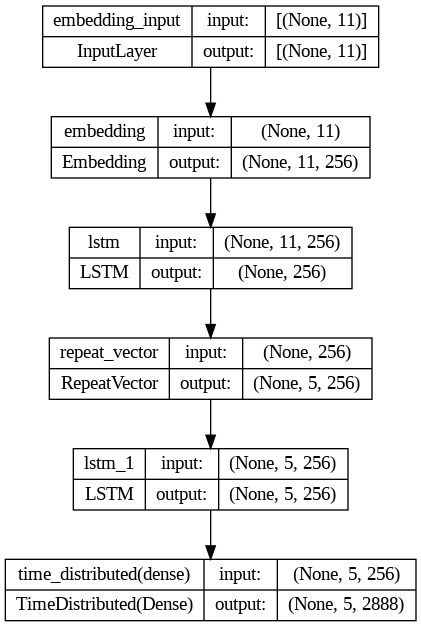

In [5]:
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

## **Building and Training Model**

In [16]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu # to give a score to a model from  0 to 1  

# load a clean dataset
def load_clean_sentences(filename):
  return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# max sentence length
def max_length(lines):
  return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X
  
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
  prediction = model.predict(source, verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src, _ = raw_dataset[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_dataset[i, 1], raw_target, translation))
    actual.append([raw_target.split()])
    predicted.append(translation.split())
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


  
# load datasets
dataset = load_clean_sentences('/content/english-french-both.pkl')
train = load_clean_sentences('/content/english-french-train.pkl')
test = load_clean_sentences('/content/english-french-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare french tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])

# load model
model = load_model('/content/model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)
 

train
src=[jen ai ma claque], target=[i have had it], predicted=[i have on it]
src=[jetais la], target=[i was there], predicted=[i was here]
src=[cest la fin], target=[this is the end], predicted=[this is the turn]
src=[je suis stupefait], target=[im astonished], predicted=[im astonished]
src=[jai les clefs de tom], target=[i have toms key], predicted=[i have tom key]
src=[passe devant], target=[go ahead], predicted=[go ahead]
src=[saistu lancer], target=[can you pitch], predicted=[can you pitch]
src=[tom part], target=[tom is leaving], predicted=[tom is leaving]
src=[je me suis senti affreusement mal], target=[i felt awful], predicted=[i felt awful]
src=[je me suis senti impuissant], target=[i felt powerless], predicted=[i felt powerless]
BLEU-1: 0.891621
BLEU-2: 0.843008
BLEU-3: 0.769756
BLEU-4: 0.515676
test
src=[je suis egalement occupe], target=[im busy too], predicted=[im busy busy]
src=[cest une tour], target=[thats a tower], predicted=[its a tower]
src=[il est devenu vieux], ta